Author: Abraham Contreras

This notebook is a walkthrough of a very simple machine learning algorithm. The data used is randomly generated, consisting of two variables that have a linear relationship with added random noise. The neural network model used here is a simple two-layered fully connected directed graph. The optimisation algorithm used is stochastic gradient descent (SGD), and the loss function defined is mean squared error (MSE).
The notebook is split into 6 sections:

1. **Import** - where all necessary packages are imported as well as any other setup requirements
2. **DATA** - where data is located and imported or generated. Data cleaning may occur in this section and is recommended where possible as this is good practice.
3. **MODEL** - where the machine learning model is defined along with the optimisation algorithm, loss function, initial network parameters, and other variables that may need initialising.
4. **TRAIN** - where the data is passed through the neural network, otherwise known as 'training the model'. This is often a looped algorithm that can assess the performance of the model and make adjustments accordingly.
5. **TEST** - where (preferably unused) data is inputted into the resultant 'trained model' and its performance is assessed for a final time.

# Import necessary packages

In [1]:
# PyTorch packages
import torch
import torch.nn as nn

from tqdm import tqdm # loop progress bar
import gc # garbage collector

# standard packages for data manipulation and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# DATA: load or generate data

In [2]:
# generate two lists of numbers
x = np.random.randn(1000)
epsilon = np.random.randn(1000)
t = 3 * x + epsilon # linear relationship with noise

# convert lists to tensor
X = torch.FloatTensor(list(zip(x, t)))

# split data into training/testing sets
X1, X2 = torch.utils.data.random_split(X, [800, 200])

X_train, X_test = X[X1.indices], X[X2.indices]

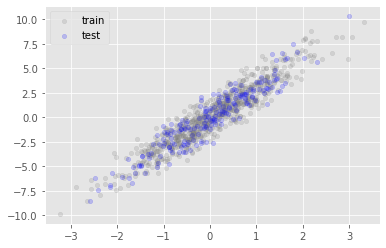

In [3]:
# examine datasets
plt.scatter(*zip(*X_train), alpha=0.2, s=20, color='grey', label='train')
plt.scatter(*zip(*X_test), alpha=0.2, s=20, color='blue', label='test')
plt.legend()

# MODEL: define the deep learning neural network 

In [4]:
# define deep learning model
class model(nn.Module):
  def __init__(self, input_layer, hidden_layer1, output_layer):
    super(model, self).__init__()
    self.layers = nn.Sequential( # set layers and links
      nn.Linear(input_layer, hidden_layer1),
      nn.Tanh(),
      nn.Linear(hidden_layer1, output_layer))
  
  def forward(self, x): #define forward propagation step
    output = self.layers(x)
    return output

# create variable for deep learning model
# set network parameters
neuralnetwork = model(input_layer=1, hidden_layer1=3, output_layer=1)

# define optimization algorithm of model and loss formula
optimizer = torch.optim.SGD(neuralnetwork.parameters(), lr=0.001)
loss = nn.MSELoss()

In [5]:
# (optional) clears some memory space
gc.collect()

136

# TRAIN: model learning step

In [6]:
total_epoch = 100 # number of training steps
batch_size = 64 # minibatch sizes
loss_list = [] 

for epoch in tqdm(range(total_epoch)):
    permu = torch.randperm(X_train.shape[0]) # randomly rearrange training data
    for i in range(0, X_train.shape[0], batch_size): # take batches from shuffled data
        indices = permu[i:i+batch_size]
        batch_x, batch_y = X_train[indices,0], X_train[indices,1]
        t = neuralnetwork.forward(batch_x.unsqueeze(1)) # forward propagation
        optimizer.zero_grad()
        l = loss(t, batch_y.unsqueeze(1)) # calculate loss 
        l.backward() # backpropagation step
        optimizer.step()

    if epoch % 1 == 0: # collect loss
        loss_list.append(l.detach())

100%|██████████| 100/100 [00:00<00:00, 237.73it/s]


# PLOT: generate predictions from trained model and plot performance

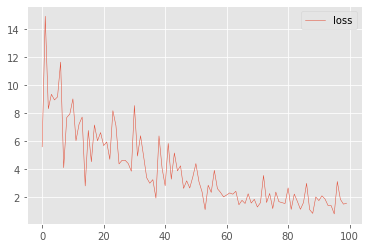

In [7]:
# Epochs vs Loss
plt.plot(range(total_epoch), np.array(loss_list), label='loss', linewidth=0.5)
plt.legend()

In [8]:
n_samples = 200 # number of test inputs
res = torch.empty(0) # empty tensor for results

for i in range(n_samples): # forward pass test dataset through trained model
    k = neuralnetwork(X_test[i:i+1,0]).detach()
    res = torch.cat((res, k), 0)

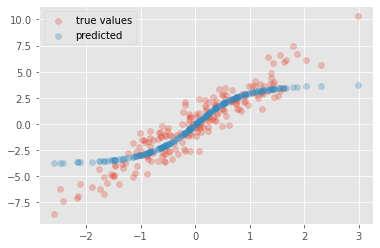

In [9]:
# plot results
plt.scatter(*zip(*X_test), alpha=0.3, label='true values')
plt.scatter(X_test[:,0] , res, alpha=0.3, label='predicted')
plt.legend()

# TEST: assess model performance

In [10]:
# calculate error of predictions
err = X_test[:,1] - res
L2norm_err = np.sqrt(np.square(err))

In [11]:
# calculate RMS score
avg_err = sum(np.sqrt(L2norm_err)) / n_samples
print("Root Mean Squared: {}.".format(avg_err))

Root Mean Squared: 0.9486280083656311.


In [12]:
# contribution to log-likelihood for each predicition point
def logprob(t, x, var=1):
    lp_list =[]
    for i in tqdm(range(len(t))):
        sigma_sqr = float(0.09)
        f = torch.distributions.normal.Normal(0, sigma_sqr)
        lp_list.append(f.log_prob(t[i]))
    return lp_list

In [13]:
# calculate total log-likelihood
LL = sum(logprob(err, X_test[:,0]))

print("\n\nLog-likelihood of predicted targets: {}.".format(LL))

100%|██████████| 200/200 [00:00<00:00, 7451.71it/s]



Log-likelihood of predicted targets: -25343.26171875.
